In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)



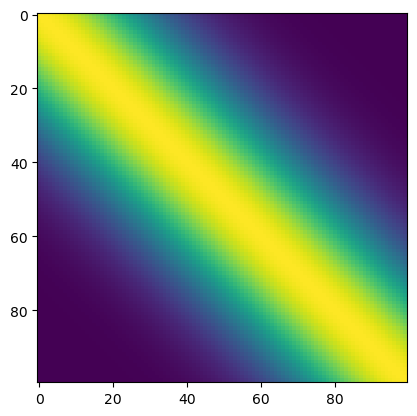

In [13]:
gamma = 10

#create meshgrid of x to construct the kernel matrix

X = np.linspace(0,1,100)
X = X[:,np.newaxis]

K = gaussian_kernel(X,X,gamma)

#display img of K
plt.imshow(K,interpolation='none')


(100, 100)


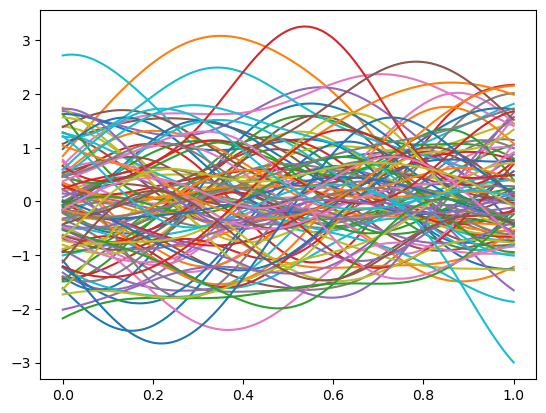

In [40]:

print(K.shape)

#sample from the prior

n_samples = 100

mu = np.zeros(K.shape[0])
f = np.random.multivariate_normal(mu,K,n_samples)

plt.plot(X,f.T)
plt.show()



In [34]:
import pandas as pd

# Specify the column names
column_names = ['year', 'month', 'decimal_date', 'average', 'interpolated', 'trend', 'days']

# Read the CSV file with the specified column names
df = pd.read_csv('co2_mm_mlo.csv', names=column_names, header=None, index_col=False)

/var/folders/sk/6zwfz76x0z34qpjtwyy0r7y40000gn/T/ipykernel_34718/1948327765.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('co2_mm_mlo.csv', names=column_names, header=None, index_col=False)


In [119]:
columns = ["year", "interpolated"]
x_ = df[columns]

#x is from years 1958-1968
x = x_[x_["year"].between(1958,1968)][["year"]].values

#x_star is from 1968-1973
x_star = x_[x_["year"].between(1969,1973)][["year"]].values

y = x_[x_["year"].between(1958,1968)][["interpolated"]].values - 1958
y_star = x_[x_["year"].between(1969,1973)][["interpolated"]].values - 1958



In [141]:
#import normalizer
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y)

x_star = x_scaler.transform(x_star)
#y_star = y_scaler.transform(y_star)



In [142]:
gamma = 0.1

K_xx = gaussian_kernel(x,x,gamma)

K_x_x_star = gaussian_kernel(x,x_star,gamma)

K_x_star_x_star = gaussian_kernel(x_star,x_star,gamma)

noise_y = 0.1

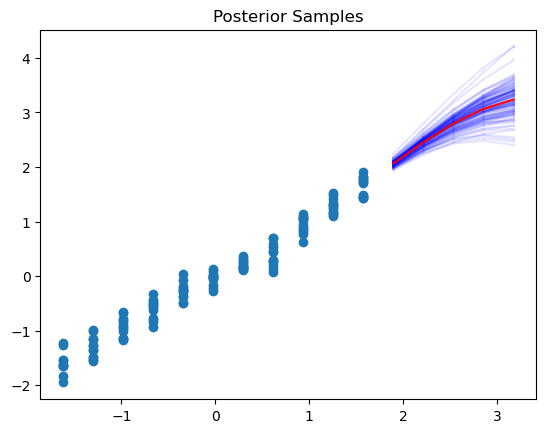

In [143]:
#using eq. 75 in the lecture notes to compute the posterior mean and covariance for f star given y
#f_star is normally distributed with mean m_star and covariance S_star
#mean_posterior = K_x_x_star * (Kxx + noise_y^2 * I)^-1 * y
#variance_posterior = K_x_x_star - K_x_x_star * (Kxx + noise_y^2 * I)^-1 * K_x_x_star.T

# Posterior mean and covariance calculations
K_x_x_star = np.array(K_x_x_star)  # Ensure this is a proper matrix
K_xx = np.array(K_xx)
K_x_star_x_star = np.array(K_x_star_x_star)
y = y.reshape(-1, 1)  # Ensure y is a column vector

# Compute the posterior mean
m_star = K_x_x_star.T @ np.linalg.inv(K_xx + noise_y**2 * np.eye(K_xx.shape[0])) @ y
m_star = m_star.flatten()  # Flatten to ensure compatibility with sampling

# Compute the posterior covariance
S_star = K_x_star_x_star - K_x_x_star.T @ np.linalg.inv(K_xx + noise_y**2 * np.eye(K_xx.shape[0])) @ K_x_x_star

# Sample from the posterior
n_samples = 100
f_star = np.random.multivariate_normal(m_star, S_star, n_samples) 

# Plot results
plt.plot(x, y, 'o', label='Training data')
for i in range(n_samples):
    plt.plot(x_star, f_star[i, :], color='blue', alpha=0.1)
plt.plot(x_star, m_star, color='red', label='Posterior mean')
plt.title('Posterior Samples')
#plt.legend()
plt.show()









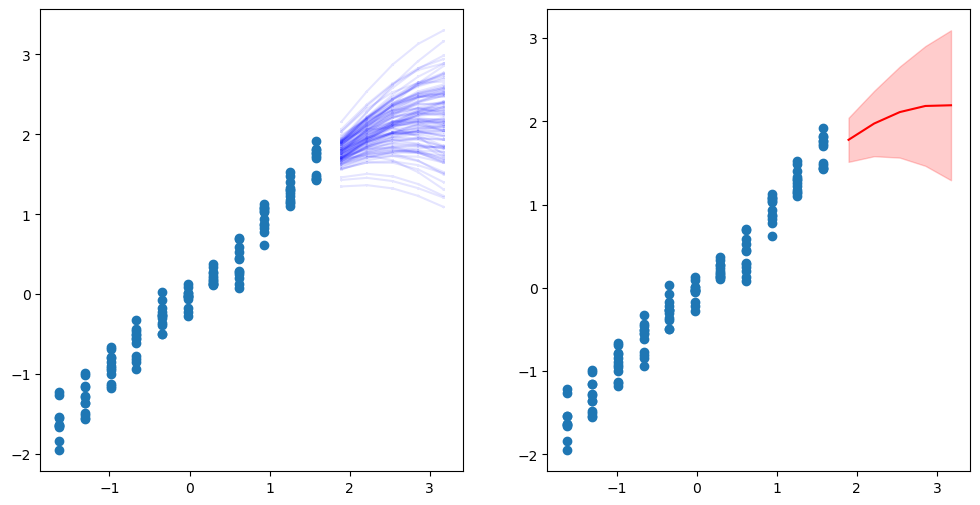

In [144]:
kernel = gaussian_kernel
gamma = 0.1
noise_y = 0.4

K_S = kernel(x, x, gamma)
G = np.linalg.inv(K_S + noise_y**2 * np.eye(K_S.shape[0]))
alpha = G @ y

K_S_x_star = kernel(x, x_star, gamma)
K_x_star_x_star = kernel(x_star, x_star, gamma)

m_star = K_S_x_star.T @ alpha
m_star = m_star.flatten() 
var_star = K_x_star_x_star - K_S_x_star.T @ G @ K_S_x_star
var_star += 1e-6 * np.eye(var_star.shape[0])

std_star = np.sqrt(np.diag(var_star))
conf95 = 1.96 * std_star




n_samples = 100
f_star = np.random.multivariate_normal(m_star, var_star, n_samples)


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.ravel()
ax[0].plot(x, y, 'o', label='Training data')
ax[1].plot(x, y, 'o', label='Training data')
for i in range(n_samples):
    ax[0].plot(x_star, f_star[i, :], color='blue', alpha=0.1)

ax[1].plot(x_star, m_star, color='red', label='Posterior mean')
ax[1].fill_between(x_star.flatten(), m_star - conf95, m_star + conf95, color='red', alpha=0.2, label='95% confidence interval')



